# Human baseline experiments

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import dcm
import networkx as nx
import json
import random
import os
from utils import get_response


palette = ['#d35400', '#34495e', '#2980b9', '#e67e22', '#f1c40f', '#7f8c8d', '#27ae60', '#16a085', '#bdc3c7', '#1abc9c', '#2ecc71', '#3498db', '#9b59b6', '#8e44ad', '#ecf0f1']

sns.set_palette(palette)


## Data cleaning and preparation

In [2]:

def llm_survey_responses(df, temperature, model='gpt-4o-mini', context='Social Network', max_count=-1):

    if os.path.exists(f"user_study_data/{context.lower()}_ranking_llm_{model.replace('/', '-')}.csv"):
        df_ranking_llm = pd.read_csv(f"user_study_data/{context.lower()}_ranking_llm_{model.replace('/', '-')}.csv")
        df_reasoning_llm = pd.read_csv(f"user_study_data/{context.lower()}_reasoning_llm_{model.replace('/', '-')}.csv")
        df_choices_llm = pd.read_csv(f"user_study_data/{context.lower()}_choices_llm_{model.replace('/', '-')}.csv")
        return df_ranking_llm, df_choices_llm, df_reasoning_llm

    df_choices_context = df.query(f'Context == "{context}" and Model == "Human"')

    if context == 'Social Network':
        profile_text = 'You are an undergraduate student at a university. You are looking for friends to connect with on a social network.'
    elif context == 'Company Network':
        profile_text = 'You are an employee at a company. You are looking for colleagues to connect with on a company network.'

    alternatives_set = df_choices_context['Alternative Set'].unique()

    records_ranking_llm = []
    records_reasoning_llm = []
    records_choices_llm = []

    rename_models = {
        'gpt-3.5-turbo' : 'GPT-3.5',
        'gpt-4o-mini' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct' : 'LLAMA-3',
        'meta/meta-llama-3-70b-instruct' : 'LLAMA-3',
        'claude-3-5-sonnet-20240620' : 'Claude 3.5',
    }

    for i, alt in enumerate(alternatives_set):

        if max_count > 0 and i >= max_count:
            break

        df_alt = df_choices_context[df_choices_context['Alternative Set'] == alt][['Name', 'Degree', 'Similarity', 'Common Friends']]

        # shuffle the rows
        df_alt = df_alt.sample(frac=1).reset_index(drop=True)  


        if context == 'Social Network':
            profiles_text = df_alt.to_json(orient='records', lines=True)      
        else:
            rename_columns = {'Similarity' : 'Type'}
            rename_values = {0 : 'Co-worker', 1 : 'Manager'}

            profiles_text = df_alt.rename(columns=rename_columns).replace(rename_values).to_json(orient='records', lines=True)

        prompt = f"""
        # Task
        Your task is to select a set of people to be friends with.

        # Profile
        {profile_text}

        # Candidate Profiles
        The cadidate profiles to be friends with are given below after chevrons:

        <PROFILES>
        {profiles_text}
        </PROFILES>

        # Output
        The output should be as a JSON object with the following structure

        {{
            "name" : name of the person you selected (integer format),
            "reason" : reason for selecting the person,
            "ranking_degree" : ranking of how much you based your decision on the degree of the person (1 = most important, 2 = average important, 3 = least important),
            "ranking_similarity" : ranking of how much you based your decision on the similarity of the person (1 = most important, 2 = average important, 3 = least important),
            "ranking_common_friends" : ranking of how much you based your decision on the number of common friends with the person (1 = most important, 2 = average important, 3 = least important)
        }}

        # Notes
        * The output must be a single JSON object ranked in the order of preference.
        * You can make at most 1 selection.
        * Your output must be contained within the json markdown cue.
        * Rankings must be mutually exclusive, i.e. you cannot have the same ranking for two different attributes.

        ```json
        """   
        
        for _ in range(3):
            try:
                ans = get_response(prompt, temperature=temperature, model=model)
                try:
                    result = json.loads(ans.split('```')[0])
                except:
                    result = json.loads(ans.split('```json')[1].split('```')[0])


                print('ALTERNATIVE SET:', alt)
                print('Result:\n', result)
                print('Alternatives:\n', profiles_text)

                records_reasoning_llm.append({
                    'Context': context,
                    'Reasoning': result['reason'],
                    'Alternative Set': alt,
                    'Model': rename_models.get(model, model),
                    'Temperature': temperature
                })

                records_ranking_llm.append({
                    'Context' : context,
                    'Score' : int(result['ranking_degree']),
                    'Type' : 'Degree',
                    'Alternative Set' : alt,
                    'Model': rename_models.get(model, model),
                    'Temperature': temperature
                })

                records_ranking_llm.append({
                    'Context' : context,
                    'Score' : int(result['ranking_similarity']),
                    'Type' : 'Similarity',
                    'Alternative Set' : alt,
                    'Model': rename_models.get(model, model),
                    'Temperature': temperature
                })

                records_ranking_llm.append({
                    'Context' : context,
                    'Score' : int(result['ranking_common_friends']),
                    'Type' : 'Common Friends',
                    'Alternative Set' : alt,
                    'Model': rename_models.get(model, model),
                    'Temperature': temperature
                })

                for alt_id in df_alt['Name'].unique():
                    records_choices_llm.append({
                        'Context': context,
                        'Alternative Set': alt,
                        'Name': int(alt_id),
                        'Choice': int(result['name']),
                        'Model': rename_models.get(model, model),
                        'Temperature': temperature,
                        'Chosen': int(int(alt_id) == int(result['name'])),
                        'Degree': int(df_alt[df_alt['Name'] == alt_id]['Degree'].values[0]),
                        'Similarity': int(df_alt[df_alt['Name'] == alt_id]['Similarity'].values[0]),
                        'Common Friends': int(df_alt[df_alt['Name'] == alt_id]['Common Friends'].values[0]),
                    })

                break
            except Exception as e:
                print('error', e)

    df_ranking_llm = pd.DataFrame(records_ranking_llm)
    df_reasoning_llm = pd.DataFrame(records_reasoning_llm)
    df_choices_llm = pd.DataFrame(records_choices_llm)

    df_ranking_llm.to_csv(f"user_study_data/{context.lower()}_ranking_llm_{model.replace('/', '-')}.csv", index=False)
    df_reasoning_llm.to_csv(f"user_study_data/{context.lower()}_reasoning_llm_{model.replace('/', '-')}.csv", index=False)
    df_choices_llm.to_csv(f"user_study_data/{context.lower()}_choices_llm_{model.replace('/', '-')}.csv", index=False)

    return df_ranking_llm, df_choices_llm, df_reasoning_llm

def prepare_user_data():
    if os.path.exists('user_study_data/ranking_human.csv'):
        df_ranking = pd.read_csv('user_study_data/ranking_human.csv')
        df_choices = pd.read_csv('user_study_data/choices_human.csv')
        df_reasoning_records = pd.read_csv('user_study_data/reasoning_human.csv')
        return df_ranking, df_choices, df_reasoning_records

    # Load the data
    df = pd.read_excel('user_study_data/user_study_4.xlsx', skiprows=[1])

    df = df[df['StartDate'] >= '2025-07-31']

    # exclude the ones with Status == 'Survey Preview'
    df = df[df['Status'] != 'Survey Preview']

    for j in [1, 2, 3]:
        df[f'SocialNetwork.Person{j}.NumberOfFriends'] = df[f'SocialNetwork.Person{j}.NumberOfFriends'].astype(int)
        df[f'SocialNetwork.Person{j}.Similarity'] = df[f'SocialNetwork.Person{j}.Similarity'].astype(int)
        df[f'SocialNetwork.Person{j}.NumberOfCommonFriends'] = df[f'SocialNetwork.Person{j}.NumberOfCommonFriends'].astype(int)

        df[f'Company.Person{j}.NumberOfFriends'] = df[f'Company.Person{j}.NumberOfFriends'].astype(int)
        df[f'Company.Person{j}.Similarity'] = df[f'Company.Person{j}.Similarity'].astype(int)
        df[f'Company.Person{j}.NumberOfCommonFriends'] = df[f'Company.Person{j}.NumberOfCommonFriends'].astype(int)


    columns_renamed = {
        'Q7_1' : '# Friends (Social Network)',
        'Q7_2' : 'Similarity (Social Network)',
        'Q7_3' : '# Common Friends (Social Network)',
        'Q9_1' : '# Friends (Company)',
        'Q9_2' : 'Similarity (Company)',
        'Q9_3' : '# Common Friends (Company)',

    }

    df['Q7_1'] = 4 - df['Q7_1'].astype(int)
    df['Q7_2'] = 4 - df['Q7_2'].astype(int)
    df['Q7_3'] = 4 - df['Q7_3'].astype(int)
    df['Q9_1'] = 4 - df['Q9_1'].astype(int)
    df['Q9_2'] = 4 - df['Q9_2'].astype(int)
    df['Q9_3'] = 4 - df['Q9_3'].astype(int)

    df = df.rename(columns=columns_renamed)

    ranking_records = []
    reasoning_records = []

    choices_records = []
    
    max_count = 200

    count_social_network = 0
    count_company = 0

    for i, row in df.iterrows():

        chosen_social_network = int(row['Q6'].split(' ')[1])
        chosen_company = int(row['Q8'].split(' ')[1])

        flag_social_network = all([row[f'SocialNetwork.Person{j}.NumberOfFriends'] >= row[f'SocialNetwork.Person{j}.NumberOfCommonFriends'] and row[f'SocialNetwork.Person{j}.NumberOfFriends'] >= 0 for j in [1, 2, 3]])
        flag_company = all([row[f'Company.Person{j}.NumberOfFriends'] >= row[f'Company.Person{j}.NumberOfCommonFriends'] and row[f'Company.Person{j}.NumberOfCommonFriends'] >= 0 for j in [1, 2, 3]])

        count_social_network += int(flag_social_network)
        count_company += int(flag_company)

        for j in [1, 2, 3]:
            record_social_network = {
                'Degree' : int(row[f'SocialNetwork.Person{j}.NumberOfFriends']),
                'Similarity' : int(row[f'SocialNetwork.Person{j}.Similarity']),
                'Common Friends' : int(row[f'SocialNetwork.Person{j}.NumberOfCommonFriends']),
                'Chosen' : int(j == chosen_social_network),
                'Alternative Set' : i,
                'Name' : j,
                'Choice' : chosen_social_network,
                'Model' : 'Human',
                'Temperature' : -1,
                'Context' : 'Social Network'
            }
            record_company = {
                'Degree' : int(row[f'Company.Person{j}.NumberOfFriends']),
                'Similarity' :  int(row[f'Company.Person{j}.Similarity']),
                'Common Friends' : int(row[f'Company.Person{j}.NumberOfCommonFriends']),
                'Chosen' : int(j == chosen_company),
                'Alternative Set' : i,
                'Name' : j,
                'Choice' : chosen_company,
                'Model' : 'Human',
                'Temperature' : -1,
                'Context' : 'Company Network'
            }

            if flag_social_network and count_social_network <= max_count:
                choices_records.append(record_social_network)

            if flag_company and count_company <= max_count:
                choices_records.append(record_company)

        if flag_social_network and count_social_network <= max_count:
            ranking_records.append({
                'Context' : 'Social Network',
                'Score' : int(row['# Friends (Social Network)']),
                'Type' : 'Degree',
                'Alternative Set' : i,
                'Model' : 'Human',
                'Temperature' : -1
            })
            ranking_records.append({
                'Context' : 'Social Network',
                'Score' : int(row['Similarity (Social Network)']),
                'Type' : 'Similarity',
                'Alternative Set' : i,
                'Model' : 'Human',
                'Temperature' : -1
            })
            ranking_records.append({
                'Context' : 'Social Network',
                'Score' : int(row['# Common Friends (Social Network)']),
                'Type' : 'Common Friends',
                'Alternative Set' : i,
                'Model' : 'Human',
                'Temperature' : -1
            })

            reasoning_records.append({
                'Context' : 'Social Network',
                'Reasoning' : row['Q11'],
                'Alternative Set' : i,
                'Model' : 'Human',
                'Temperature' : -1
            })

        if flag_company and count_company <= max_count:
            ranking_records.append({
                'Context' : 'Company Network',
                'Score' : int(row['# Friends (Company)']),
                'Type' : 'Degree',
                'Alternative Set' : i,
                'Model' : 'Human',
                'Temperature' : -1
            })
            ranking_records.append({
                'Context' : 'Company Network',
                'Score' : int(row['Similarity (Company)']),
                'Type' : 'Similarity',
                'Alternative Set' : i,
                'Model' : 'Human',
                'Temperature' : -1
            })
            ranking_records.append({
                'Context' : 'Company Network',
                'Score' : row['# Common Friends (Company)'],
                'Type' : 'Common Friends',
                'Alternative Set' : i,
                'Model' : 'Human',
                'Temperature' : -1
            })

            reasoning_records.append({
                'Context' : 'Company Network',
                'Reasoning' : row['Q12'],
                'Alternative Set' : i,
                'Model' : 'Human',
                'Temperature' : -1
            })

    df_ranking = pd.DataFrame(ranking_records)
    df_choices = pd.DataFrame(choices_records)

    df_reasoning_records = pd.DataFrame(reasoning_records)
    df_reasoning_records = df_reasoning_records.dropna(subset=['Reasoning'])

    df_ranking.to_csv('user_study_data/ranking_human.csv', index=False)
    df_choices.to_csv('user_study_data/choices_human.csv', index=False)
    df_reasoning_records.to_csv('user_study_data/reasoning_human.csv', index=False)

    return df_ranking, df_choices, df_reasoning_records

def prepare_all_data(models, contexts=['Social Network', 'Company Network']):

    df_ranking, df_choices, df_reasoning_records = prepare_user_data()

    for model in models:
        print(f'Processing model: {model}')
        for context in contexts:
            print(f'Processing context: {context}')
            df_ranking_llm, df_choices_llm, df_reasoning_llm = llm_survey_responses(df_choices, temperature=0.5, model=model, context=context)
            
            df_ranking = pd.concat([df_ranking, df_ranking_llm], ignore_index=True)
            df_choices = pd.concat([df_choices, df_choices_llm], ignore_index=True)
            df_reasoning_records = pd.concat([df_reasoning_records, df_reasoning_llm], ignore_index=True)

    df_ranking.to_csv('user_study_data/ranking_all.csv', index=False)
    df_choices.to_csv('user_study_data/choices_all.csv', index=False)
    df_reasoning_records.to_csv('user_study_data/reasoning_all.csv', index=False)

    return df_ranking, df_choices, df_reasoning_records

## Model-Human Comparisons

In [3]:

def plot_correlations(df_ranking, df_choices, contexts, models):
    """    Plot the within-model correlation coefficients for the ranking scores of different features.
    """
    # plot ranking correlation heatmap
    records_within_corr_coeffs = []
    records_between_corr_coeffs = []
    records_between_models = []
    records_effects = []


    feature_names = ['Degree', 'Similarity', 'Common Friends']

    rename_feature_names = {
        'Degree' : '$\\hat \\theta_{PA}$',
        'Similarity' : '$\\hat \\theta_{H}$',
        'Common Friends' : '$\\hat \\theta_{TC}$'
    }

    models_and_human = ['Human'] + models

    rename_models = {
        'gpt-3.5-turbo' : 'GPT-3.5',
        'gpt-4o-mini' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct' : 'LLAMA-3',
        'meta/meta-llama-3-70b-instruct' : 'LLAMA-3',
        'claude-3-5-sonnet-20240620' : 'Claude 3.5',     
    }

    df_ranking = df_ranking.sort_values(by=['Context', 'Model', 'Alternative Set', 'Type'])
    df_choices = df_choices.sort_values(by=['Context', 'Model', 'Alternative Set', 'Name'])

    for context in contexts:
        n_context = len(df_ranking.query(f'Context == "{context}"')['Alternative Set'].unique())
        print(f'Processing context: {context} (n_{context} = {n_context})')

        for model in models_and_human:
            df_ranking_model = df_ranking.query(f'Context == "{context}" and Model == "{rename_models.get(model, model)}"').sort_values(by=['Alternative Set', 'Type'])

            degree_scores = df_ranking_model.query('Type == "Degree"')['Score'].values
            similarity_scores = df_ranking_model.query('Type == "Similarity"')['Score'].values
            common_friends_scores = df_ranking_model.query('Type == "Common Friends"')['Score'].values

            # Stack the scores
            scores = np.stack([degree_scores, similarity_scores, common_friends_scores], axis=1)

            corr_coeffs = []

            for i in range(scores.shape[0]):
                for j in range(i + 1, scores.shape[0]):
                    corr = np.corrcoef(scores[i], scores[j])[0, 1]
                    corr_coeffs.append(corr)

                    records_within_corr_coeffs.append({
                        'Context': context,
                        'Model': rename_models.get(model, model),
                        'Spearman Correlation': corr,
                    })

        for i, model1 in enumerate(models_and_human):
            for j, model2 in enumerate(models_and_human):
                if model1 == model2:
                    records_between_corr_coeffs.append({
                        'Context': context,
                        'Model 1': rename_models.get(model1, model1),
                        'Model 2': rename_models.get(model2, model2),
                        'Spearman Correlation': 1.0,
                        '$L_2$ Distance': 0.0
                    })
                else:
                    df_ranking_model1 = df_ranking.query(f'Context == "{context}" and Model == "{rename_models.get(model1, model1)}"').sort_values(by=['Alternative Set', 'Type'])
                    df_ranking_model2 = df_ranking.query(f'Context == "{context}" and Model == "{rename_models.get(model2, model2)}"').sort_values(by=['Alternative Set', 'Type'])

                    degree_scores_model1 = df_ranking_model1.query('Type == "Degree"')['Score'].values
                    similarity_scores_model1 = df_ranking_model1.query('Type == "Similarity"')['Score'].values
                    common_friends_scores_model1 = df_ranking_model1.query('Type == "Common Friends"')['Score'].values

                    degree_scores_model2 = df_ranking_model2.query('Type == "Degree"')['Score'].values
                    similarity_scores_model2 = df_ranking_model2.query('Type == "Similarity"')['Score'].values
                    common_friends_scores_model2 = df_ranking_model2.query('Type == "Common Friends"')['Score'].values

                    # Stack the scores
                    scores_model1 = np.stack([degree_scores_model1, similarity_scores_model1, common_friends_scores_model1], axis=1).mean(axis=0)

                    scores_model2 = np.stack([degree_scores_model2, similarity_scores_model2, common_friends_scores_model2], axis=1).mean(axis=0)

                    corr_coeff = np.corrcoef(np.argsort(scores_model1), np.argsort(scores_model2))[0, 1]
                    distance = np.linalg.norm(scores_model1 - scores_model2)

                    records_between_corr_coeffs.append({
                        'Context': context,
                        'Model 1': rename_models.get(model1, model1),
                        'Model 2': rename_models.get(model2, model2),
                        'Spearman Correlation': corr_coeff, 
                        '$L_2$ Distance': distance
                    })

        for i, model1 in enumerate(models_and_human):
            for j, model2 in enumerate(models_and_human):
                df_choices_model1 = df_choices.query(f'Context == "{context}" and Model == "{rename_models.get(model1, model1)}"').sort_values(by=['Alternative Set', 'Name'])
                df_choices_model2 = df_choices.query(f'Context == "{context}" and Model == "{rename_models.get(model2, model2)}"').sort_values(by=['Alternative Set', 'Name'])

                distance_mean, distance_std, theta_spearman, theta1, theta2, sd1, sd2, ame1, ame2, sdame1, sdame2, p_values_ame1, p_values_ame2 = dcm.compare_models(df_choices_model1, df_choices_model2, on='Alternative Set', method='tv', bias=True, feature_names=feature_names, log_transform=True, exclude_log=[], calculate_p_values=True, calculate_average_marginal_effects=True)

                records_between_models.append({
                    'Context': context,
                    'Model1': rename_models.get(model1, model1),
                    'Model2': rename_models.get(model2, model2),
                    'TV Distance': distance_mean,
                    'TV Distance Std': distance_std,
                    'Effect Spearman Correlation': theta_spearman,
                    'Theta1': theta1,  
                    'Theta2': theta2,
                    'StandardError1': sd1,
                    'StandardError2': sd2,
                    'AME1' : ame1,
                    'AME2' : ame2,
                    'StandardErrorAME1': sdame1,
                    'StandardErrorAME2': sdame2,
                })

                for j, feature in enumerate(feature_names):
                    
                    records_effects.append({
                        'Context': context,
                        'Model': rename_models.get(model1, model1),
                        'Feature': rename_feature_names[feature],
                        'Effect': theta1[j],
                        'Standard Error': sd1[j],
                        'AME': ame1[j],
                        'Standard Error AME': sdame1[j]
                    })




    # Create DataFrame for within-model correlation coefficients
    df_within_corr_coeffs = pd.DataFrame(records_within_corr_coeffs)
    df_between_corr_coeffs = pd.DataFrame(records_between_corr_coeffs)
    df_between_model = pd.DataFrame(records_between_models)
    df_effects = pd.DataFrame(records_effects)


    fig, ax = plt.subplots(figsize=(4, 4))
    sns.barplot(data=df_within_corr_coeffs, x='Context', y='Spearman Correlation', hue='Model', ax=ax)
    ax.set_ylim(0, 1)
    
    sns.despine()

    ax.legend(title='Model', loc='upper left')

    ax.set_title('Within-Model Correlation')

    fig.tight_layout()
    fig.savefig('figures/user_study/within_model_correlation_coefficients.png')

    fig1, ax1 = plt.subplots(2, 2, figsize=(6, 6), squeeze=False)
    fig2, ax2 = plt.subplots(2, 2, figsize=(6, 6), squeeze=False)
    fig3, ax3 = plt.subplots(2, 2, figsize=(9, 6), squeeze=False)

    for i, context in enumerate(contexts):
        sns.heatmap(df_between_corr_coeffs.query(f'Context == "{context}"').pivot(index='Model 1', columns='Model 2', values='Spearman Correlation'),
                    annot=True, fmt='.2f', ax=ax1[0, i],
                    cbar=(i == len(contexts) - 1),
                    vmin=-1, vmax=1)
        
        sns.heatmap(df_between_corr_coeffs.query(f'Context == "{context}"').pivot(index='Model 1', columns='Model 2', values='$L_2$ Distance'),
                    annot=True, fmt='.2f', ax=ax1[1, i],
                    cbar=(i == len(contexts) - 1),
                    vmin=0)

        sns.heatmap(df_between_model.query(f'Context == "{context}"').pivot(index='Model1', columns='Model2', values='TV Distance'),
                    annot=True, fmt='.2f', ax=ax2[0, i],
                    cbar=(i == len(contexts) - 1),
                    vmin=0, vmax=1)
        
        sns.heatmap(df_between_model.query(f'Context == "{context}"').pivot(index='Model1', columns='Model2', values='Effect Spearman Correlation'),
                    annot=True, fmt='.2f', ax=ax2[1, i],
                    cbar=(i == len(contexts) - 1),
                    vmin=-1, vmax=1)

       

        sns.barplot(df_effects.query(f'Context == "{context}"'),
                    x='Feature', y='Effect', ax=ax3[0, i],
                    palette=palette[:len(models)],
                    hue='Model', legend=(i == 1))

        for bars, (name, group) in zip(ax3[0, i].containers, df_effects.query(f'Context == "{context}"').groupby('Model')):
            for bar, (_, row) in zip(bars, group.iterrows()):
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                err = row['Standard Error']
                ax3[0, i].errorbar(x, y, yerr=err, fmt='none', c='black', capsize=3)

        sns.barplot(df_effects.query(f'Context == "{context}"'),
                    x='Feature', y='AME', ax=ax3[1, i],
                    palette=palette[:len(models)],
                    hue='Model', legend=(i == 1))

        for bars, (name, group) in zip(ax3[1, i].containers, df_effects.query(f'Context == "{context}"').groupby('Model')):
            for bar, (_, row) in zip(bars, group.iterrows()):
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                err = row['Standard Error AME']
                ax3[1, i].errorbar(x, y, yerr=err, fmt='none', c='black', capsize=3)

        if i == 1:
            # move legend to the right of the ax
            ax3[0, i].legend(loc='upper left', bbox_to_anchor=(1, 1))
            ax3[1, i].legend(loc='upper left', bbox_to_anchor=(1, 1))


        ax1[0, i].set_title(f'{context}')
        ax2[0, i].set_title(f'{context}')
        ax3[0, i].set_title(f'{context}')

    for i in range(ax1.shape[0] - 1):
        for j in range(ax1.shape[1]):
            ax1[i, j].set_xticks([])

    for i in range(ax2.shape[0] - 1):
        for j in range(ax2.shape[1]):
            ax2[i, j].set_xticks([])

    for j in range(1, ax1.shape[1]):
        for i in range(ax1.shape[0]):
            ax1[i, j].set_yticks([])

    for j in range(1, ax2.shape[1]):
        for i in range(ax2.shape[0]):
            ax2[i, j].set_yticks([])

    for i in range(ax1.shape[0]):
        for j in range(ax1.shape[1]):
            ax1[i, j].set_xlabel('')
            ax1[i, j].set_ylabel('')
            sns.despine(ax=ax1[i, j])

    for i in range(ax2.shape[0]):
        for j in range(ax2.shape[1]):
            ax2[i, j].set_xlabel('')
            ax2[i, j].set_ylabel('')
            sns.despine(ax=ax2[i, j])

    for i in range(ax3.shape[0]):
        for j in range(ax3.shape[1]):
            ax3[i, j].set_xlabel('')
            ax3[i, j].set_ylabel('')
            sns.despine(ax=ax3[i, j])

    ax1[0, 0].set_ylabel('Spearman Correlation')
    ax1[1, 0].set_ylabel('$L_2$ Distance')
    ax2[0, 0].set_ylabel('TV Distance')
    ax2[1, 0].set_ylabel('Spearman Correlation')
    ax3[0, 0].set_ylabel('Effect')
    ax3[1, 0].set_ylabel('Average Marginal Effect')

    fig1.suptitle('Borda Counts')
    fig2.suptitle('Effects')
    fig3.suptitle('Effects')

    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()

    fig1.savefig('figures/user_study/between_model_borda.png', dpi=300, bbox_inches='tight')
    fig2.savefig('figures/user_study/between_model_effects.png', dpi=300, bbox_inches='tight')
    fig3.savefig('figures/user_study/effects.png', dpi=300, bbox_inches='tight')

## Plots

Processing model: gpt-4o-mini
Processing context: Social Network
Processing context: Company Network
Processing model: gpt-3.5-turbo
Processing context: Social Network
Processing context: Company Network
Processing model: claude-3-5-sonnet-20240620
Processing context: Social Network
Processing context: Company Network
Processing model: meta/meta-llama-3-70b-instruct
Processing context: Social Network
Processing context: Company Network
Processing context: Social Network (n_Social Network = 100)


/Users/marios/miniconda3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/marios/miniconda3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Processing context: Company Network (n_Company Network = 103)


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_15527/1359505821.py:554: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(df_effects.query(f'Context == "{context}"'),
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_15527/1359505821.py:566: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(df_effects.query(f'Context == "{context}"'),
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_15527/1359505821.py:554: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(df_effects.query(f'Context == "{context}"'),
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_15527/1359505821.py:566: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an u

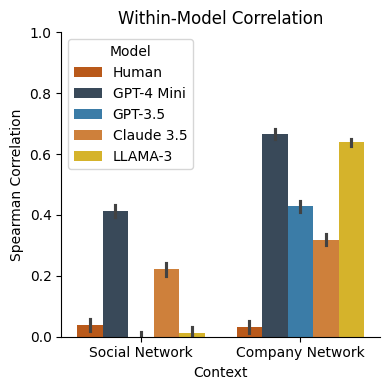

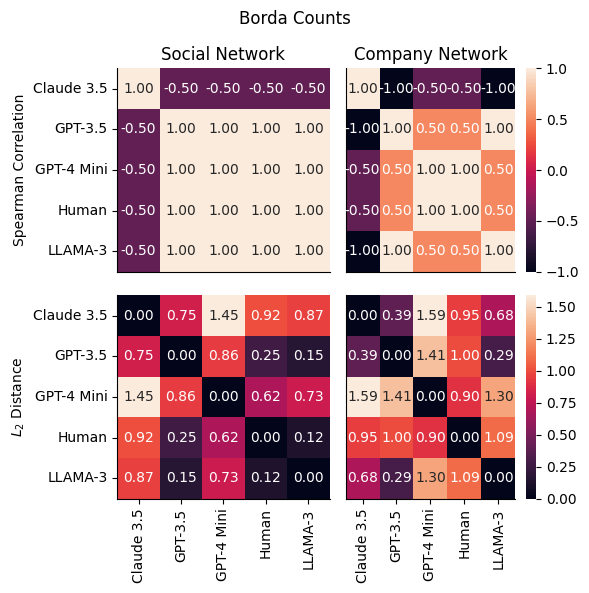

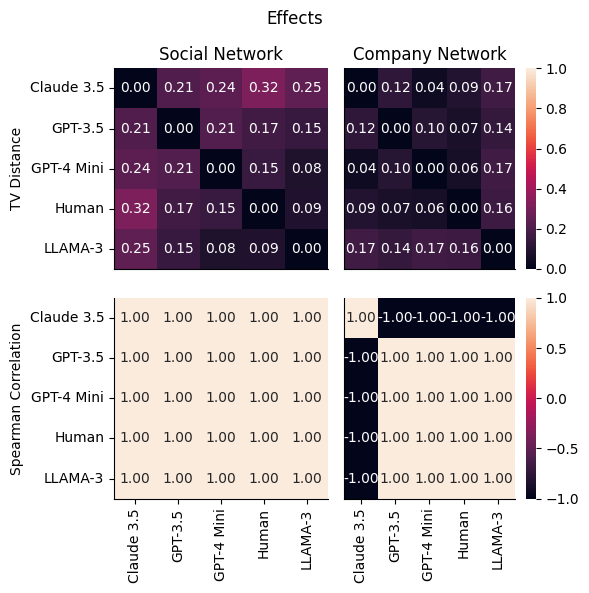

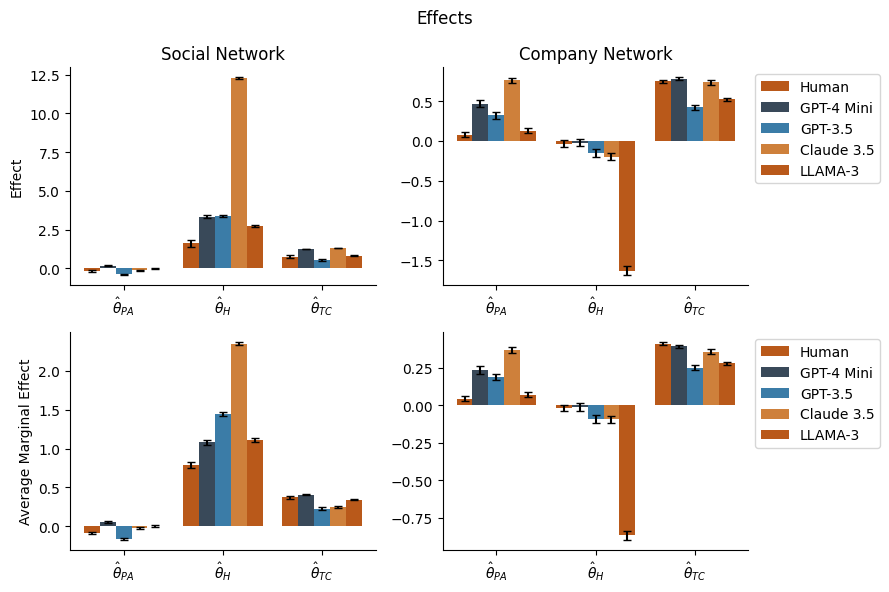

In [ ]:
models = ['gpt-4o-mini', 'gpt-3.5-turbo', 'claude-3-5-sonnet-20240620', 'meta/meta-llama-3-70b-instruct']
contexts = ['Social Network', 'Company Network']

# Data preparation (not needed if files ranking_all.csv, choices_all.csv, reasoning_all.csv exist in path user_study_data/)
# df_ranking, df_choices, df_reasoning_records = prepare_all_data(models, contexts)

df_ranking = pd.read_csv('user_study_data/ranking_all.csv')
df_choices = pd.read_csv('user_study_data/choices_all.csv')
df_reasoning_records = pd.read_csv('user_study_data/reasoning_all.csv')

plot_correlations(df_ranking, df_choices, contexts, models)
